# Introduction
In this notebook, we will explore the [Toxic comments dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) and after performing some EDA, we will build a deep learning model and save it.

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, inflect, unicodedata
from string import punctuation
from sklearn.model_selection import train_test_split

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Peeking the dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/train.csv', engine='python')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.shape

(159571, 8)

In [6]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### EDA and cleaning the text

In [8]:
df_label_counts =pd.DataFrame(df[df.columns[2:]].sum(axis=0), columns=['Count']).reset_index()

In [9]:
df_label_counts.head()

,index,Count
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877


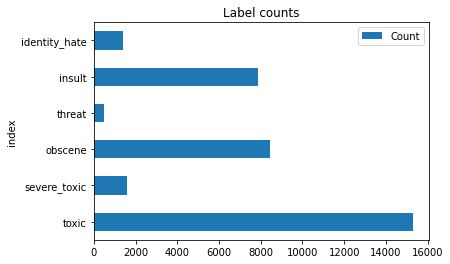

In [10]:
df_label_counts.plot(x='index', y='Count', kind='barh', title='Label counts')

In [11]:
def to_lowercase(text):
  return text.lower()

def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
  PUNCT_TO_REMOVE = punctuation
  PUNCT_TO_REMOVE += '’'
  clean_txt = ''.join([ch for ch in text if ch not in PUNCT_TO_REMOVE])
  return clean_txt

def tokenize_text(text):
  return word_tokenize(text)

def remove_stop_words(text):
  STOP_WORDS = stopwords.words('english')
  new_words = []
  for word in text:
    if word not in STOP_WORDS:
      new_words.append(word)
  return new_words

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  lem_list = [lemmatizer.lemmatize(word) for word in text]
  return lem_list

def clean_text(text):
  text = to_lowercase(text)
  text = remove_urls(text)
  text = remove_emoji(text)
  text = remove_punctuation(text)
  text = tokenize_text(text)
  text = remove_stop_words(text)
  text = remove_non_ascii(text)
  text = lemmatize_text(text)
  return text

In [12]:
df['CleanText'] = df['comment_text'].apply(lambda x: clean_text(x))

In [13]:
df[['comment_text', 'CleanText']].head()

,comment_text,CleanText
0,Explanation\nWhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,"[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...","[cant, make, real, suggestion, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page, thats]"


In [14]:
df['CleanText'] = df['CleanText'].apply(lambda x: ' '.join(ch for ch in x))

In [15]:
df[['comment_text', 'CleanText']].head()

,comment_text,CleanText
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


In [16]:
df_toxic_labels = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
df_toxic_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [17]:
x = df['CleanText'].values
y = df_toxic_labels.values

In [18]:
x[:4]

array(['explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted new york doll fac please dont remove template talk page since im retired now892053827',
       'daww match background colour im seemingly stuck thanks talk 2151 january 11 2016 utc',
       'hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
       'cant make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later noone else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipediagoodarticlenominationstransport'],
      dtype=object)

In [19]:
y[:4]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [21]:
print(f'X_train shape = {X_train.shape}\nX_test shape = {X_train.shape}')
print(f'y_train shape = {y_train.shape}\ny_test shape = {y_test.shape}')

X_train shape = (127656,)
X_test shape = (127656,)
y_train shape = (127656, 6)
y_test shape = (31915, 6)


### Model building

In [24]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle

In [23]:
tokenizer = Tokenizer(num_words=7000) #Taking 7000 most frequent words.
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200 #Maximum length of the sentence as a sequenced token.

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
pickle.dump(tokenizer, open('/content/drive/MyDrive/tokenizer.pkl', 'wb'))

In [ ]:
X_train[:2]

array([[  38,   29,   57,  326, 1449, 5429,  736, 5665,   38, 1072,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
#Making an embedding matrix from a pre trained word2vec glove model.

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = records[1:]
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix[:3]

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0. 

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
model1.add(LSTM(units=128))
model1.add(Dense(6, activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         19739900  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 19,857,922
Trainable params: 118,022
Non-trainable params: 19,739,900
_________________________________________________________________


In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('toxic_comm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model1.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/5
798/798 [==============================] - 47s 49ms/step - loss: 0.1780 - accuracy: 0.8778 - val_loss: 0.1394 - val_accuracy: 0.9939

Epoch 00001: val_accuracy improved from -inf to 0.99385, saving model to toxic_comm_model.h5
Epoch 2/5
798/798 [==============================] - 39s 48ms/step - loss: 0.1401 - accuracy: 0.9937 - val_loss: 0.1397 - val_accuracy: 0.9915

Epoch 00002: val_accuracy did not improve from 0.99385
Epoch 3/5
798/798 [==============================] - 38s 48ms/step - loss: 0.1411 - accuracy: 0.9925 - val_loss: 0.1390 - val_accuracy: 0.9911

Epoch 00003: val_accuracy did not improve from 0.99385
Epoch 4/5
798/798 [==============================] - 38s 48ms/step - loss: 0.1285 - accuracy: 0.9806 - val_loss: 0.0701 - val_accuracy: 0.9941

Epoch 00004: val_accuracy improved from 0.99385 to 0.99409, saving model to toxic_comm_model.h5
Epoch 5/5
798/798 [==============================] - 38s 48ms/step - loss: 0.0694 - accuracy: 0.9934 - val_loss: 0.0635 - val

In [ ]:
score = model1.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 17s 17ms/step - loss: 0.0657 - accuracy: 0.9936
Test Score: 0.06569061428308487
Test Accuracy: 0.993639349937439


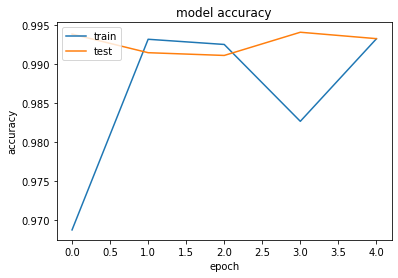

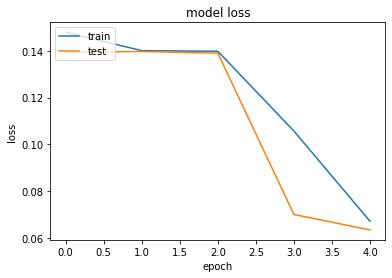

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Trying the model on a custom text.
text = 'You should die and you are a piece of shit.'
text = clean_text(text)
text = ' '.join(ch for ch in text)
text = np.asarray([text])
text

array(['die piece shit'], dtype='<U14')

In [ ]:
text_seq = tokenizer.texts_to_sequences(text)
text_seq = pad_sequences(text_seq, maxlen = maxlen, padding='post')
text_seq

array([[330, 486, 201,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
predicted_value = model1.predict(text_seq)

In [ ]:
for i in range(predicted_value.shape[0]):
  for j in range(6):
    if predicted_value[i][j] >= 0.5:
        predicted_value[i][j] = 1
    else:
        predicted_value[i][j] = 0

In [ ]:
print('["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]')
predicted_value

["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


array([[1., 0., 1., 0., 1., 0.]], dtype=float32)

The results are pretty accurate. Hence, with this we come to an end. 

### Final thoughts
We can try different approaches for multilabel classification such as using machine learning algorithms. However, in my opinion, deep learning works perfectly with this type of problem. Our model is ready to be used as a REST API.